<a href="https://colab.research.google.com/github/julienierwinski/PatchCamelyonMLProject/blob/main/CNN_PCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install necessary libraries
Includes Keras, h5py, and torch

In [8]:
# Install Keras 3, Keras Tuner, and h5py library using pip

%pip install -q keras-core keras-tuner h5py

In [9]:
# Set the Keras backend to Torch
import os
os.environ["KERAS_BACKEND"] = "torch"

In [10]:
# Import keras, h5py, numpy, and torch libraries
import keras
import h5py
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [11]:
# Import the drive module from google.colab to mount Google Drive
from google.colab import drive
# Mount Google Drive to the '/content/drive' directory
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create Dataloader for PCam Dataset
Needs to open the HDF5 files to read them, return image and label samples

In [12]:
# Define class to load data from HDF5 files for PCam dataset

class PCamHDF5Dataset:
    # Constructor to initialize dataset with paths to image and label HDF5 files
    def __init__(self, hdf5_image_path, hdf5_label_path, image_dataset_name='x', label_dataset_name='y'):

        self.image_file = h5py.File(hdf5_image_path, 'r')
        self.label_file = h5py.File(hdf5_label_path, 'r')

        self.images = self.image_file[image_dataset_name]
        self.labels = self.label_file[label_dataset_name]

    # Method to return total number of samples in dataset
    def __len__(self):
        return self.images.shape[0]

    # Method to retrieve single sample (image and label) by index
    def __getitem__(self, index):

        image = self.images[index].reshape(96, 96, 3).astype('float32')

        label = self.labels[index].squeeze()

        return image, label

    # Method to close the HDF5 files
    def close(self):
        if self.image_file:
            self.image_file.close()
            self.image_file = None
        if self.label_file:
            self.label_file.close()
            self.label_file = None

    # Destructor to ensure the HDF5 files are closed
    def __del__(self):
        self.close()

# Initialize Convolutional Neural Network (CNN) Architecture

In [13]:
# # Import necessary Keras layers for building a Convolutional Neural Network (CNN)
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model

# Define the expected input shape of the images (height, width, channels)
# PCam has images of size 96x96 with 3 color channels (RGB)
input_shape = (96, 96, 3)

inputs = Input(shape=input_shape)

# Add a Conv2D layer with 16 filters, 3x3 kernel, and ReLU activation
# Normalize by dividing by 255
x = Conv2D(16, (3, 3), activation='relu')(inputs/255.0)

# Add a MaxPooling2D layer with a 2x2 pool size a
x = MaxPooling2D((2, 2), strides=(2,2))(x)

# Add another Conv2D layer with 32 filters, a 3x3 kernel, and ReLU activation
x = Conv2D(32, (3, 3), activation='relu')(x)

# Add another MaxPooling2D layer for further downsampling
x = MaxPooling2D((2, 2), strides=(2,2))(x)

# Flatten output of convolutional layers
x = Flatten()(x)

# Add Dense layer with 128 units and ReLU activation
x = Dense(128, activation='relu')(x)

# Use sigmoid function to return output
outputs = Dense(1, activation="sigmoid")(x)

# Create the Model by specifying input and output layers
model = Model(inputs=inputs, outputs=outputs)

# Print a summary of the model architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,987,809 (7.58 MB)

 Trainable params: 1,987,809 (7.58 MB)

 Non-trainable params: 0 (0.00 B)

# Define Optimizer, Loss, and other Evaluation Metrics Used for Training

In [14]:
# Import the libraries needed for optimizer (Adam), metrics, and loss function
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy
from keras.metrics import AUC
from keras.losses import BinaryCrossentropy

# Define the optimizer. Using Adam optimizer with default learning rate.
optimizer = Adam()

# Define binary cross-entropy loss
loss = BinaryCrossentropy()

# Define the metrics to evaluate during training
ROC_AUC = AUC(name='roc_auc', curve='ROC')
PR_AUC = AUC(name='pr_auc', curve='PR')
metrics = [BinaryAccuracy(), ROC_AUC, PR_AUC]

# Optimal learning rate found by brief hyperpramater tuning
lr = .001

# Compile the model
model.compile(optimizer=Adam(learning_rate=lr), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), ROC_AUC, PR_AUC])


In [15]:
# Define the file paths for the training, validation, and test datasets stored in Google Drive
train_image_file_path = '/content/drive/MyDrive/pcam/camelyonpatch_level_2_split_train_x.h5'
train_label_file_path = '/content/drive/MyDrive/pcam/camelyonpatch_level_2_split_train_y.h5'

val_image_file_path = '/content/drive/MyDrive/pcam/camelyonpatch_level_2_split_valid_x.h5'
val_label_file_path = '/content/drive/MyDrive/pcam/camelyonpatch_level_2_split_valid_y.h5'

test_image_file_path = '/content/drive/MyDrive/pcam/camelyonpatch_level_2_split_test_x.h5'
test_label_file_path = '/content/drive/MyDrive/pcam/camelyonpatch_level_2_split_test_y.h5'


# Define the batch size for training and evaluation
batch_size = 128

# Create instances of the custom PCamHDF5Dataset for training, validation, and test sets
train_dataset = PCamHDF5Dataset(train_image_file_path, train_label_file_path)
val_dataset = PCamHDF5Dataset(val_image_file_path, val_label_file_path)
test_dataset = PCamHDF5Dataset(test_image_file_path, test_label_file_path)

# Create PyTorch DataLoader instances for each dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Define the number of training epochs
epochs = 10

# Implement early stopping for efficiency
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train and Validate the CNN Model, then Test

In [16]:
model.fit(train_dataloader, validation_data=val_dataloader, epochs=epochs, callbacks=[early_stop])

Epoch 1/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 166s 71ms/step - binary_accuracy: 0.7588 - loss: 0.5083 - pr_auc: 0.8128 - roc_auc: 0.8329 - val_binary_accuracy: 0.7772 - val_loss: 0.4780 - val_pr_auc: 0.8595 - val_roc_auc: 0.8621
Epoch 2/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 50s 25ms/step - binary_accuracy: 0.8261 - loss: 0.3941 - pr_auc: 0.8990 - roc_auc: 0.9031 - val_binary_accuracy: 0.7791 - val_loss: 0.4926 - val_pr_auc: 0.8695 - val_roc_auc: 0.8699
Epoch 3/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - binary_accuracy: 0.8582 - loss: 0.3366 - pr_auc: 0.9281 - roc_auc: 0.9304 - val_binary_accuracy: 0.7995 - val_loss: 0.4426 - val_pr_auc: 0.8771 - val_roc_auc: 0.8836
Epoch 4/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - binary_accuracy: 0.8763 - loss: 0.2978 - pr_auc: 0.9443 - roc_auc: 0.9458 - val_binary_accuracy: 0.8113 - val_loss: 0.4580 - val_pr_auc: 0.8950 - val_roc_auc: 0.8901
Epoch 5/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 50s 24ms/step - binary_accuracy: 0.8914 - loss: 0.2663 - pr_a

In [21]:
# Now, test on test set

model.evaluate(test_dataloader)


256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - binary_accuracy: 0.7634 - loss: 0.5470 - pr_auc: 0.8563 - roc_auc: 0.8463


[0.5505788922309875, 0.760894775390625, 0.8434289693832397, 0.8500573039054871]

# Visualize Some PCam Samples

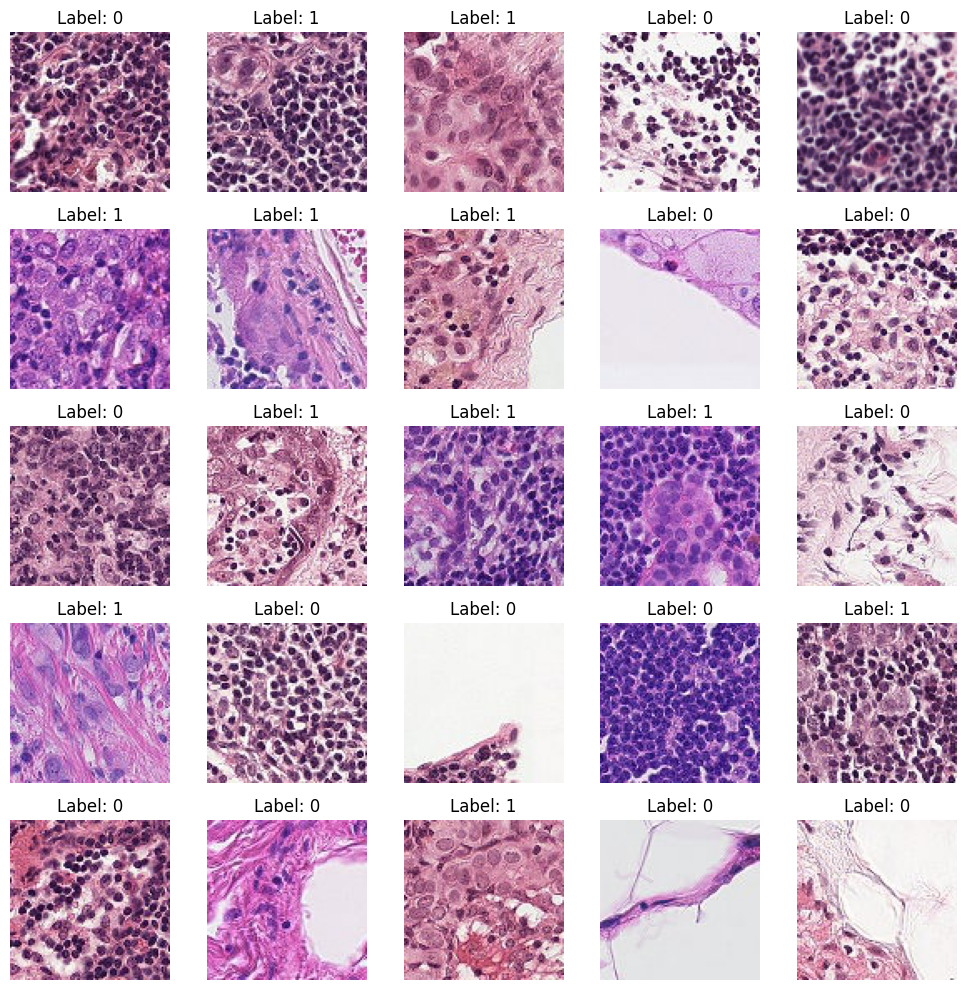

In [19]:
# Import the matplotlib.pyplot library for plotting
import matplotlib.pyplot as plt

# Get the first batch of data from the training dataloader
first_batch = next(iter(train_dataloader))

images, labels = first_batch

# Determine the grid size (5x5)
grid_size = 5
num_images_to_display = grid_size * grid_size

# Create a figure and a grid of subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

axes = axes.flatten()

# Iterate through the first `num_images_to_display` images in the batch
for i in range(num_images_to_display):

    img = images[i]
    label = labels[i]

    # Convert the PyTorch Tensor image to a NumPy array and then to uint8 format for displaying
    # Use imshow() to display the image on the current subplot
    axes[i].imshow(img.numpy().astype('uint8'))
    axes[i].set_title(f"Label: {label.item()}")
    axes[i].axis('off')

plt.tight_layout()

# Display the plot
plt.show()